In [54]:
# Import required libraries
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [55]:
# Read and inspect dataset
weather = pd.read_csv("london_weather.csv")
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [56]:
# Check shape of dataset, data types, and missing values 
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


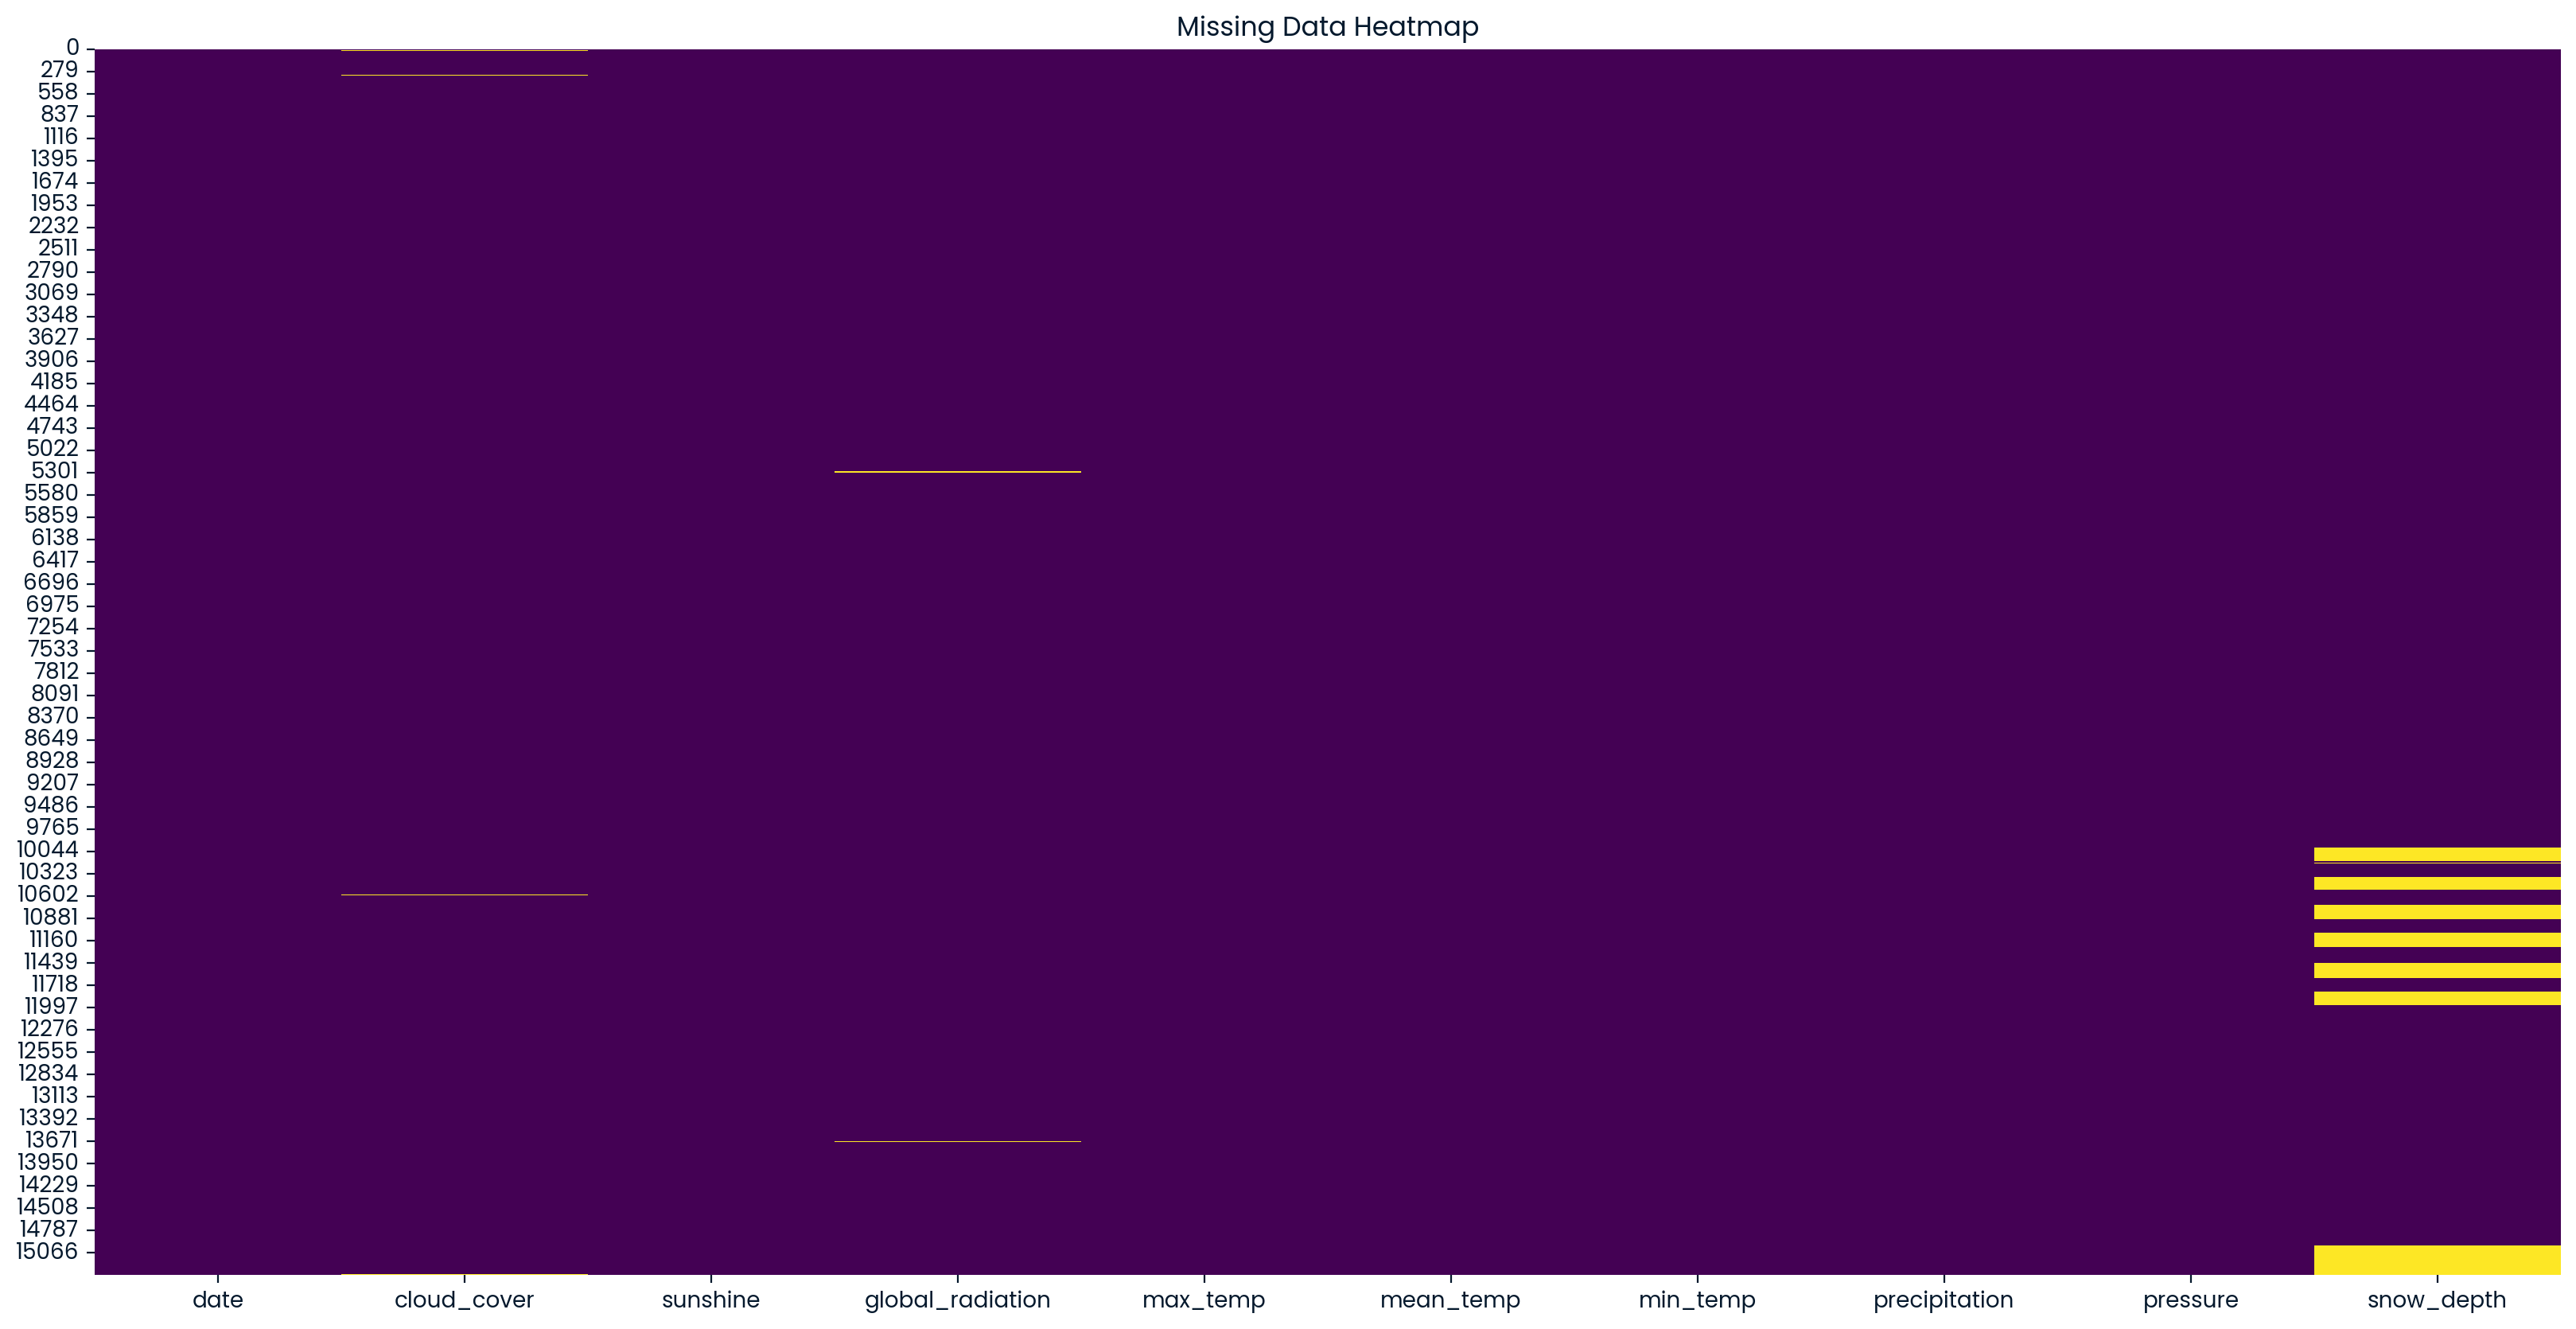

In [57]:
# Visualise missing values
plt.figure(figsize=(20, 10))
sns.heatmap(weather.isna(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [58]:
# Convert the date column to datetime and extract month and year
weather['date'] = pd.to_datetime(weather['date'], format="%Y%m%d")
weather['month'] = weather['date'].dt.month
weather['year'] = weather['date'].dt.year

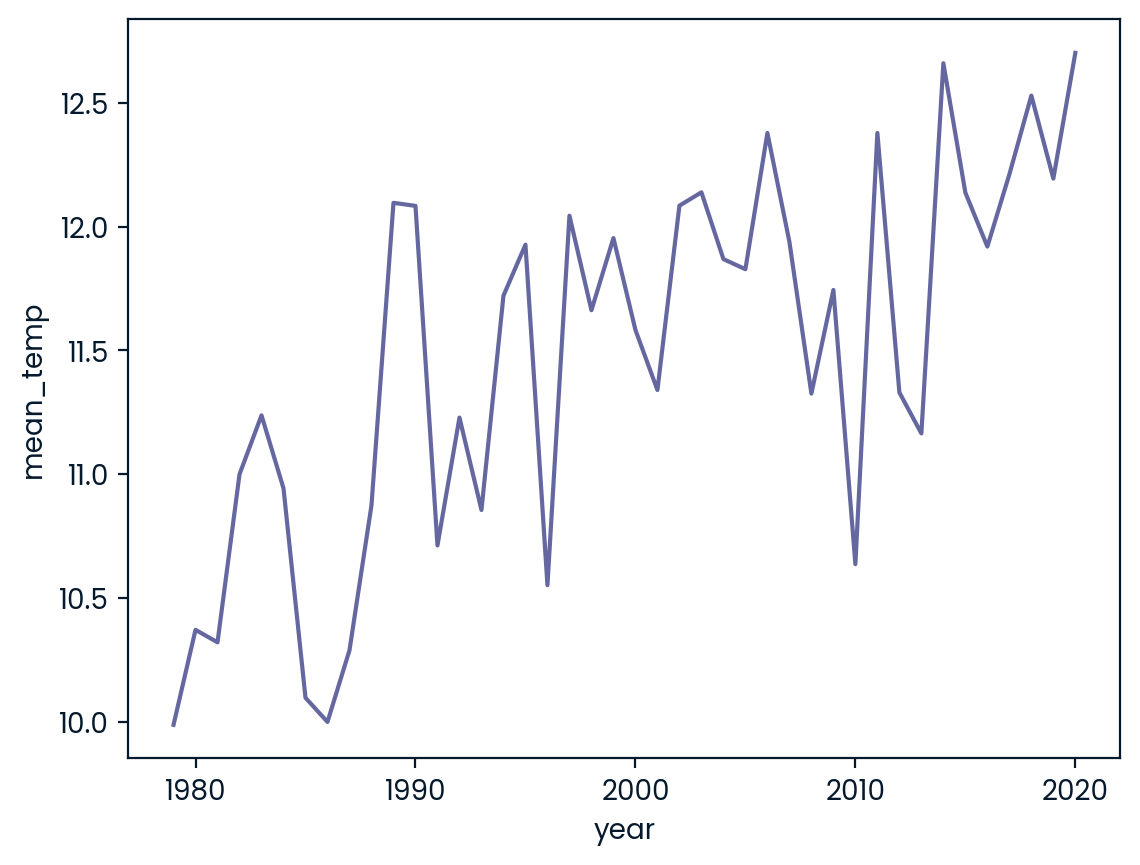

In [59]:
# Visualise mean temperature by year
temp_per_month = weather.groupby(by='year', as_index = False)['mean_temp'].mean()

sns.lineplot(x='year', y='mean_temp', data=temp_per_month, ci=None)
plt.show()

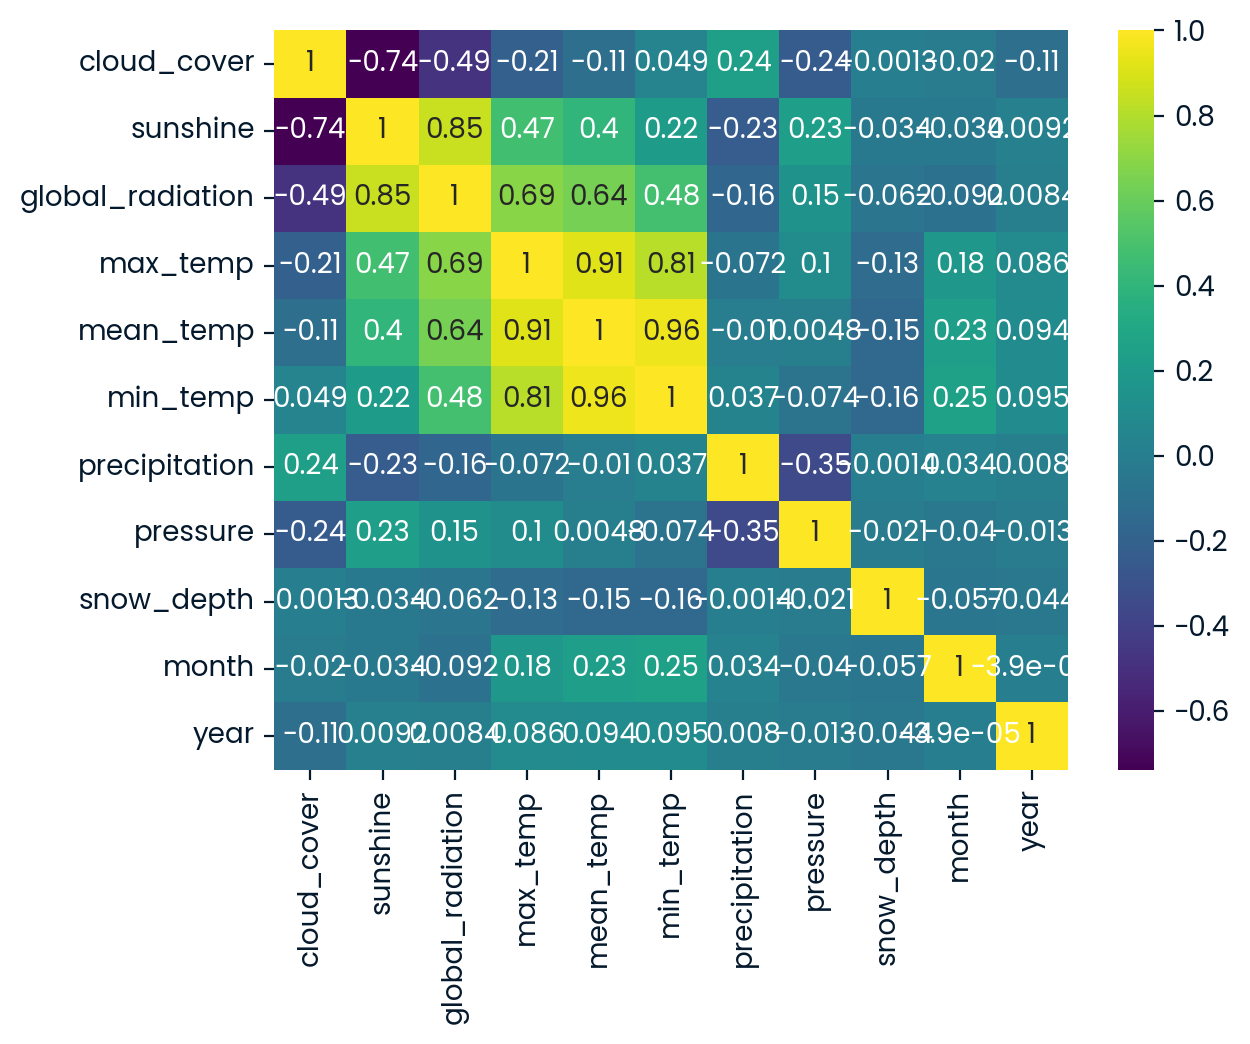

In [60]:
# Visualise correlations between features
correlation_matrix = weather.corr()

sns.heatmap(correlation_matrix,cmap='viridis', annot=True)
plt.show()

In [61]:
# Select features to predict the target variable (mean temperature)
feature_selection = ['cloud_cover','sunshine', 
                     'global_radiation', 
                     'precipitation', 
                     'pressure', 
                     'month']

target_var = 'mean_temp'

# Drop missing values in the target variable
weather = weather.dropna(subset=target_var)

In [62]:
# Subset the Dataframe to make a feature set X and target set y
X = weather[feature_selection]
y = weather['mean_temp']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [63]:
# Create a pipeline to preprocess the data by inputting missing values and normalising features
steps = [("imputation", SimpleImputer()),
        ("scaler", StandardScaler())]
         
pipeline = Pipeline(steps)

# Preprocess the train and test sets separately to avoid data leakage
X_train_norm = pipeline.fit_transform(X_train)
X_test_norm = pipeline.transform(X_test)

In [64]:
# Build a linear regression, decision tree, and random forest regressors and test several hyperparameters ('max_depth') 

for idx, depth in enumerate([1, 2, 5, 10, 20]): 
    run_name = f"run_{idx}"
    with mlflow.start_run(run_name=run_name):
        # Create models
        lin_reg = LinearRegression().fit(X_train_norm, y_train)
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(X_train_norm, y_train)
        forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(X_train_norm, y_train)
        # Log models
        mlflow.sklearn.log_model(lin_reg, "lin_reg")
        mlflow.sklearn.log_model(tree_reg, "tree_reg")
        mlflow.sklearn.log_model(forest_reg, "forest_reg")
        # Evaluate performance
        y_pred_lin_reg = lin_reg.predict(X_test_norm)
        lin_reg_rmse = mean_squared_error(y_test, y_pred_lin_reg, squared=False)
        y_pred_tree_reg = tree_reg.predict(X_test_norm)
        tree_reg_rmse = mean_squared_error(y_test, y_pred_tree_reg, squared=False)
        y_pred_forest_reg = forest_reg.predict(X_test_norm)
        forest_reg_rmse = mean_squared_error(y_test, y_pred_forest_reg, squared=False)
        # Log performance
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_lr", lin_reg_rmse)
        mlflow.log_metric("rmse_tr", tree_reg_rmse)
        mlflow.log_metric("rmse_fr", forest_reg_rmse)